# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pprint as pp
%matplotlib inline

## Read in an Image

Image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


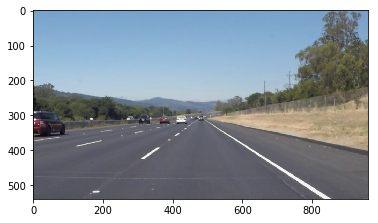

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')


#printing out some stats and plotting
print('Image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math
from collections import deque
from enum import Enum

class LineDrawing(Enum):
    CANNY = 1                 # draw lines without processing
    LINEAR_INTERPOLATION = 2  # try to interpolate and find the average line between all lines
    LINE_AVERAGE = 3          # will weight each line for its importance and interpolate with a polygon for better results
    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold, 10)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


DEGREES_CONVERTION = 180 / np.pi 

def line_angle(p1x, p1y, p2x, p2y):
    return math.atan((p2x - p1x)/(p2y - p1y)) * DEGREES_CONVERTION


def get_lines_in_range(lines, alpha, delta):
    """
    Returns all lines in a given angle range
        (alpha - delta) < line angele < (alpha + delta)
    """
    result = deque()
    
    min_angle = alpha - delta
    max_angle = alpha + delta
    #print(min_angle, max_angle)
    
    for line_list in lines:
        for p1x, p1y, p2x, p2y in line_list:
            angle = line_angle(p1x, p1y, p2x, p2y)
            if min_angle <= angle <= max_angle:
                result.append(((p1x, p1y), (p2x, p2y)))
                #print((p1x, p1y), (p2x, p2y), '%s°' % angle)
            
    return result


def interpolate_on_all_lines(lines, bottomLeft, topLeft, topRight, bottomRight):
    """
    Will interpolate all points between the top and bottom Y coordiantes of the polygon with 
        a polynome of order 1 and step 10 pixels.
        
    `bottomLeft`, `topLeft`, `topRight`, `bottomRight` are the vertexes of the polygon
    """
    points = deque()
    for line in lines:
        points.append(line[0])
        points.append(line[1])
    
    if len(points) == 0:
        return []
    
    xs = np.array([p[0] for p in points])
    ys = np.array([p[1] for p in points])
    
    p = np.poly1d(np.polyfit(ys, xs, 1))
    
    interpolated_points = deque()
    
    start = min(bottomLeft[1], bottomRight[1])
    stop = max(topLeft[1], topRight[1])
    
    y_points = np.linspace(start, stop, 10)
    for y in y_points:
        x = p(y)
        interpolated_points.append((int(x), int(y)))
    
    return line_points(interpolated_points)

def make_line_equation(p1, p2):
    """ Builds a line equation fucntion. """
    def f(y):
        return ((y-p1[1])*(p2[0]-p1[0]))/(p2[1]-p1[1]) + p1[0]
    return f

def int_point(p):
    x, y = p
    return int(x), int(y)

def interpolate_yx(ys, xs, ys_range, degree):
    """ Utility interpolation function """
    interpolated_points = deque()
    p = np.poly1d(np.polyfit(ys, xs, degree))
    for y in ys_range:
        x = p(y)
        interpolated_points.append((x, y))

    return interpolated_points

def compute_line_average(lines, dim_y, bottomLeft, topLeft, topRight, bottomRight, tails_points=40):
    """
    Will weight each line by its importance(length) and interpolate point by point each value of the line to 
        extract an average line passing in the middle of all lines.
    The resulting array of segments, will have some missing data, in between segments and between
        the last segment and the polygon and the first segment and the polygon
        
    For data missing in between, lines are drawn to connect the sgments.
    For data missing at the edges, linear interpolation is used, building a polygon with the last `tails_points`
        points and extrapolating.
    
    `dim_y` is the y dimension of the image
    
    `bottomLeft`, `topLeft`, `topRight`, `bottomRight` are the vertexes of the polygon
    
    `tails_points` is the amout of points used to create the interpolating function to reach the edges of the polygon
    """
    
    # sort tuples to be in order (y1 > y2)
    sorted_line_tuples = deque()
    for p1, p2 in lines:
        if p2[1] > p1[1]:
            sorted_line_tuples.append((p2, p1))
        else:
            sorted_line_tuples.append((p1, p2))
    sorted_line_tuples = list(sorted_line_tuples)

    # sort lines from top to bottom
    sorted_lines = sorted(sorted_line_tuples, key=lambda tup: tup[0][1])

    # create a buffer to store for each point of Y a weight from each contributing line
    y_buffer = [deque() for _ in range(dim_y)]

    for li, (p1,p2) in enumerate(sorted_lines):
        weight = p1[1]- p2[1]
        for yi in range(p2[1], p1[1]+1):
            # append tuple (index, weight)
            y_buffer[yi].append((li, weight))

    for y, y_indexes in enumerate(y_buffer):
        if len(y_indexes) > 0:
            xs = 0
            weights = 0
            for y_ind, weight in y_indexes:
                xs += make_line_equation(*sorted_lines[y_ind])(y) * weight
                weights += weight
            x = xs / weights
            y_buffer[y] = x 


    # Fill buffer with None before starting numbers and before end numbers
    for y, x in enumerate(y_buffer):
        if isinstance(x, deque):
            y_buffer[y] = None
        else:
            break
    y_buffer_size = len(y_buffer) -1
    for y, x in enumerate(reversed(y_buffer)):
        if isinstance(x, deque):
            y_buffer[y_buffer_size - y] = None
        else:
            break

    # Find segments which are missing in the middle
    missing_lines = deque()

    last_element = None
    is_last_a_number = False
    is_last_deque = False
    for y, x in enumerate(y_buffer):
        if x is None:
            last_element = None
            continue

        is_deque = isinstance(x, deque)
        is_none = x is None
        is_a_number = not is_deque and not is_none

        if is_deque and is_last_a_number:
            missing_lines.append((y_buffer[y-1], y, 1))
        if is_last_deque and is_a_number:
            missing_lines.append((y_buffer[y], y, 2))

        is_last_deque = is_deque
        is_last_a_number = is_a_number

    #pp.pprint(missing_lines)   

    for f1, f2 in pairwise(missing_lines):
        if not(f1[2] == 1 and f2[2] == 2):
            raise ValueError("Something when wrong with the line interpolation")

        p1 = f1[0], f1[1]
        p2 = f2[0], f2[1]
        f = make_line_equation(p1, p2)
        for y in range(p1[1], p2[1]+1):
            y_buffer[y] = f(y)
    
    # Extract points for the final interpolation to clear out the lines
    
    px = deque()
    py = deque()

    for y, x in enumerate(y_buffer):
        if x is not None:
            px.append(x)
            py.append(y)
    
    interpolated_points = list(interpolate_yx(py, px, range(min(py), max(py)), 2))
    #interpolated_points = [(x, y) for x, y in zip(px, py)]
    
    # Compute interpolation at the and start of the interval to close the lines
    s_pts = interpolated_points[:tails_points]
    e_pts = interpolated_points[-tails_points:]
                                              
    s_pts_x = [p[0] for p in s_pts]
    s_pts_y = [p[1] for p in s_pts]
    e_pts_x = [p[0] for p in e_pts]
    e_pts_y = [p[1] for p in e_pts]

    bottom_y = min(bottomLeft[1], bottomRight[1])
    top_y = max(topLeft[1], topRight[1])
                                              
    top_part = interpolate_yx(s_pts_y, s_pts_x, range(top_y, min(s_pts_y) - 1), 1)
    bottom_part = interpolate_yx(e_pts_y, e_pts_x, range(max(e_pts_y), bottom_y + 1), 1)
    
    interpolated_points.extend(bottom_part)
    interpolated_points.extend(top_part)
        
    return interpolated_points

def draw_lines(img, lines, polygon, alpha, delta, drawing_mode, color=[255, 0, 255], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    lines_in_range = get_lines_in_range(lines, alpha, delta)
    
    
    if drawing_mode == LineDrawing.CANNY:
        for p1, p2 in lines_in_range:
            cv2.line(img, p1, p2, color, thickness)
            
    elif drawing_mode == LineDrawing.LINEAR_INTERPOLATION:
        bottomLeft, topLeft, topRight, bottomRight = polygon
        lines_to_draw = interpolate_on_all_lines(lines_in_range, bottomLeft, topLeft, topRight, bottomRight)
        
        for p1, p2 in lines_to_draw:
            cv2.line(img, p1, p2, color, thickness)

    elif drawing_mode == LineDrawing.LINE_AVERAGE:
        bottomLeft, topLeft, topRight, bottomRight = polygon
        points_to_draw = compute_line_average(lines_in_range, image.shape[1], 
                                              bottomLeft, topLeft, topRight, bottomRight)
        
        # Please note points are not totally orderd by their `y` coordinate, although no sorting is needed
        for p in points_to_draw:
            int_p = int_point(p)
            cv2.line(img, int_p, int_p, color, thickness)
            
    else:
        raise ValueError("Please provide a valid '%s' mode" % LineDrawing)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, polygon, alpha, delta, drawing_mode):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, polygon, alpha, delta, drawing_mode)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def line_points(iterable):
    """
    Converts a polygon iterable into a list of line points to draw:
        [p0, p1, p2, p3] -> (p0, p1), (p1, p2), (p2, p3), (p3, p1)
    """
    if len(iterable) == 0:
        raise ValueError("Please provide a valid polygon")
        
    final_iterable = list(iterable) + [iterable[0]]
    p1 = iter(final_iterable)
    p2 = iter(final_iterable)
    p2.__next__()
    return zip(p1, p2)


def draw_ploygon(image, polygon, color=[0, 255, 0], thickness=3):
    """ Draws on top of an existing image"""
    for p1, p2 in line_points(polygon):
        p1 = tuple(int(x) for x in p1)
        p2 = tuple(int(x) for x in p2)
        cv2.line(image, p1,p2, color, thickness)
        

def make_hsv_ranges_min_max(hue, delta=4):
    min_color = np.array([hue - delta, 100, 100], np.uint8)
    max_color = np.array([hue + delta, 255, 255], np.uint8)
    return min_color, max_color

def make_hsv(h, s, v):
    return np.array([h, s, v], np.uint8)

def plot_image(image):
    """ Provide an image and creates a new figure and plots rgb or grayscale images """
    plt.figure()
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)


def rgb_bgr_image(image):
    b,g,r = cv2.split(image)
    return cv2.merge((r,g,b))

def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

In [4]:
# Polygons are used as filters for selecting the regions of interest
# They must have the following structure: bottomLeft, topLeft, topRight, bottomRight

def integer_polygon(polygon):
    return [(int(p[0]), int(p[1])) for p in polygon]


def cutting_polygon_function_entire_image(imshape):
    """ Returns a polygon containig the entire image area"""
    return integer_polygon([
        (imshape[1] * 0.0, imshape[0] * 0.0),
        (imshape[1] * 0.0, imshape[0] * 1.0), 
        (imshape[1] * 1.0, imshape[0] * 1.0), 
        (imshape[1] * 1.0 ,imshape[0] * 0.0)
    ])

def left_cutting_polygon(imshape):
    return integer_polygon([
        (imshape[1] * 0.09, imshape[0] * 1.00),
        (imshape[1] * 0.45, imshape[0] * 0.62), 
        (imshape[1] * 0.55, imshape[0] * 0.62), 
        (imshape[1] * 0.23, imshape[0] * 1.00)
    ])

def right_cutting_polygon(imshape):
    return integer_polygon([
        (imshape[1] * 0.80, imshape[0] * 1.00),
        (imshape[1] * 0.505, imshape[0] * 0.62), 
        (imshape[1] * 0.56, imshape[0] * 0.62), 
        (imshape[1] * 0.97, imshape[0] * 1.00),

    ])    

In [5]:
# Report output function

def save_report_image(image, name, width=300, height=169, out_dir="img_references"):
    """
    Images will be scaled to a fixed height and width. in a
    """
    out_path = os.path.join(out_dir, "%s.jpg" % name)
    resized = cv2.resize(image, (width, height))
    cv2.imwrite(out_path, cv2.cvtColor(resized, cv2.COLOR_RGB2BGR), [int(cv2.IMWRITE_JPEG_QUALITY), 100])

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os

DIR = "test_images"

test_images = [os.path.join(DIR, x) for x in os.listdir(DIR)]

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Image info:  (720, 1280, 3)


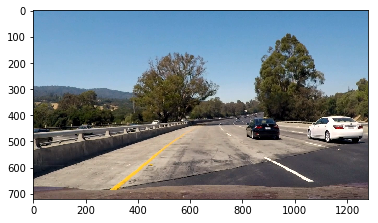

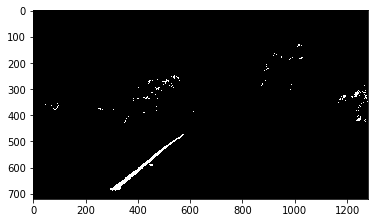

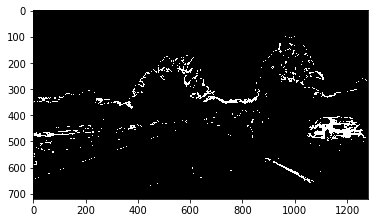

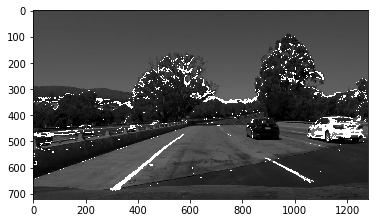

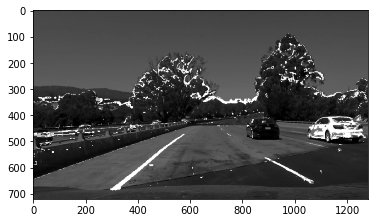

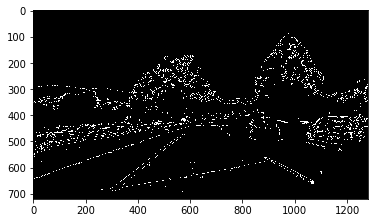

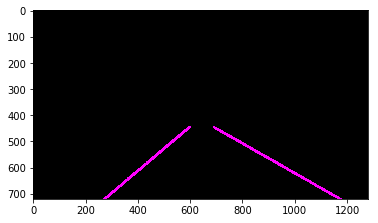

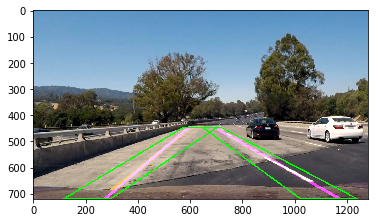

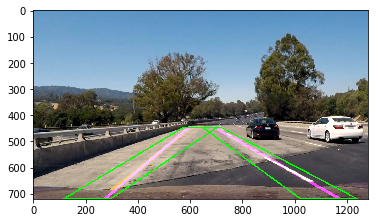

In [7]:
def process_image_v2(img, polygon_builders, alphas, deltas, drawing_mode,
                    print_debug=False, debug_ploygon=False):
    """
    `polygon_builders` list of functions like the ones defined above, used to ouput 
        a polygon in the image coordinates
    
    `alphas` list of angles 0° - 360° used to filter hugh lines:
        `LineDrawing.CANNY` draws lines as they are detected by the helper function
        `LineDrawing.LINEAR_INTERPOLATION` will interpolate and find the average line between all lines
        `LineDrawing.LINE_AVERAGE` will weight each line by its importance(length) and interpolate
            all values to extract a smoother result
    
    `deltas` list of angle deltas in degrees, together with the alpha they provide the range in which
        hough lines are detected
    
    `drawing_mode` selcts which method should be used to draw Hough Lines 
    
    `print_debug` prints in the console the list of intermediate images used to obtain the final result
    
    `debug_ploygon` prints the outlines of the polygons
    
    """
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Select all `yellow colors` for lane line detection
    yellow_min_hsv, yellow_max_hsv = make_hsv_ranges_min_max(21, delta=10)
    yellow_hsv_mask = cv2.inRange(hsv_img, yellow_min_hsv, yellow_max_hsv)
    
    # Select all `white colors` in the entire image
    white_min_hsv = make_hsv(6, 0, 50)
    white_max_hsv = make_hsv(110, 21, 255)
    white_hsv_mask = cv2.inRange(hsv_img, white_min_hsv, white_max_hsv)

    selected_colors = weighted_img(yellow_hsv_mask, white_hsv_mask, 1., 1., 0.)
        
    # lowering gray image luminosity, prevents edge detection in white / black asphalt
    gray_image = (grayscale(img).astype(float) * 0.50).astype(np.uint8)
    
    # Sum the mask selections of yellow and white to the gray image to use in the detector
    gray_overlap = weighted_img(gray_image, selected_colors, 1., 1., 0.)
        
    blurred_overlap = gaussian_blur(gray_overlap, kernel_size=5)
    image_edges = canny(blurred_overlap, low_threshold=50, high_threshold=150)
    
    # Hough lines are detected only in certain areas delimited by polygons
    # In each polygon lines must have a certain slople in range of `alpha ± delta` provided in degrees
    # All detections are summed togherer in a final image
    hough_lines_images = deque()
    
    for polygon_builder, alpha, delta in zip(polygon_builders, alphas, deltas):
        polygon = polygon_builder(image_edges.shape)

        vertices = np.array([polygon], dtype=np.int32)
        masked_image = region_of_interest(image_edges, vertices)

        hough_lines_image = hough_lines(masked_image,
                                        rho=2, theta=np.pi/180, threshold=35, min_line_len=5, max_line_gap=10,
                                        polygon=polygon, alpha=alpha, delta=delta, drawing_mode=drawing_mode)
        hough_lines_images.append(hough_lines_image)
    
    hough_lines_images = list(hough_lines_images)
    complete_hough_lines_image = hough_lines_images[0]
        
    for partial_hough_image in hough_lines_images[1:]:
        complete_hough_lines_image = weighted_img(complete_hough_lines_image, partial_hough_image, 1., 1., 0.)
    
    # Overlapping of lines on top of the original image
    weighted_image = weighted_img(complete_hough_lines_image, img, 1., 1., 0.)
    
    # Draws on top of the final result the polygons indicating the detection area
    if debug_ploygon:
        for polygon_builder in polygon_builders:
            draw_ploygon(weighted_image, polygon_builder(image_edges.shape))
    
    # Plots in the console the intermediate steps of the pipeline
    if print_debug:
        plot_image(img)
        plot_image(yellow_hsv_mask)
        plot_image(white_hsv_mask)
        plot_image(gray_overlap)
        plot_image(blurred_overlap)
        plot_image(image_edges)
        plot_image(complete_hough_lines_image)
        plot_image(weighted_image)
    
    return weighted_image

def wrapped_process_image(img, drawing_mode, print_debug, debug_ploygon):
    return process_image_v2(img, polygon_builders=[left_cutting_polygon, right_cutting_polygon], 
                            alphas=[-50, 60], deltas=[10, 10],
                            drawing_mode=drawing_mode,
                            print_debug=print_debug, debug_ploygon=debug_ploygon)

def pipeline_process_image(img):
    return wrapped_process_image(img, drawing_mode=LineDrawing.LINE_AVERAGE, 
                                 print_debug=False, debug_ploygon=False)

def test_function(drawing_mode, print_debug, debug_ploygon):
    # Extract an image from the challenge clip and use it to test
    #vidcap = cv2.VideoCapture('test_videos/solidWhiteRight.mp4')
    #vidcap = cv2.VideoCapture('test_videos/solidYellowLeft.mp4')
    vidcap = cv2.VideoCapture('test_videos/challenge.mp4')
    vidcap.set(cv2.CAP_PROP_POS_MSEC, 4200)
    success, img = vidcap.read()
    if success:
        img = rgb_bgr_image(img)
        print('Image info: ', img.shape)
        result = wrapped_process_image(img, drawing_mode=drawing_mode, 
                                   print_debug=print_debug, debug_ploygon=debug_ploygon)
        #save_report_image(result, 'test')
        plot_image(result)
    
# Uncomment to test the base function of the detector
test_function(LineDrawing.LINEAR_INTERPOLATION, True, True)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image_frame(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline_process_image(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [10]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:08<00:00, 25.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 10.5 s, sys: 1.7 s, total: 12.2 s
Wall time: 9.01 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_frame)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:28<00:00, 23.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 34.2 s, sys: 5.26 s, total: 39.4 s
Wall time: 29.3 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_frame)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:14<00:00, 19.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 16.2 s, sys: 3.08 s, total: 19.3 s
Wall time: 15 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))